In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/MyDrive/DS_301_Project_Group_1_Picture_Colorization")

In [3]:
!ls

 data					   GANS.ipynb		 RESNET.ipynb
'Data_preprocessing other dataset.ipynb'   model		 Untitled
 dataset				   Preprocessing.ipynb	'VGG-16 on engraving.ipynb'
 evaluations				   readme.md


In [ ]:
import torch
torch.cuda.empty_cache()

In [4]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def load_image_as_tensor(image_path):
    """Load an image and convert it to a PyTorch tensor."""
    image = Image.open(image_path)
    transform = transforms.ToTensor()
    return transform(image)

def show_images(original_tensor, grayscale_tensor):
    """Display the original and grayscale images side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_tensor.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(grayscale_tensor.squeeze(), cmap='gray')
    ax[1].set_title("Grayscale Image")
    ax[1].axis('off')

    plt.show()

def process_directory(directory_path, output_directory_base):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith('.png'):
                original_image_path = os.path.join(root, file)

                # Assuming grayscale images are saved in a mirrored directory structure
                relative_path = os.path.relpath(root, directory_path)
                grayscale_image_path = os.path.join(output_directory_base, relative_path, file)

                if os.path.exists(grayscale_image_path):  # Check if the grayscale image exists
                    # Load images as PyTorch tensors
                    original_tensor = load_image_as_tensor(original_image_path)
                    grayscale_tensor = load_image_as_tensor(grayscale_image_path)

                    # Show the images
                    show_images(original_tensor, grayscale_tensor)

                return  # Process only one image per directory

# Define the paths
directory_path = r'.\dataset\training_set'  # Update this path
output_directory_base = r'.\dataset\gray_training_set'  # Update this path




# Process one image from each directory
process_directory(directory_path, output_directory_base)

In [5]:
from torchvision import transforms

# Transform for grayscale images (input)
transform_grayscale = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Transform for color images (target)
transform_color = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.utils import save_image
import os

class GrayscaleColorizationDataset(Dataset):
    def __init__(self, grayscale_dir, color_dir, transform_grayscale=None, transform_color=None):
        """
        grayscale_dir: Directory with the grayscale images.
        color_dir: Directory with the color images.
        transform_grayscale: Transforms for grayscale images.
        transform_color: Transforms for color images.
        """
        self.grayscale_dataset = ImageFolder(grayscale_dir, transform=transform_grayscale)
        self.color_dataset = ImageFolder(color_dir, transform=transform_color)

        assert len(self.grayscale_dataset) == len(self.color_dataset), \
            "Mismatched number of images between grayscale and color datasets."

    def __len__(self):
        return len(self.grayscale_dataset)

    def __getitem__(self, idx):
        grayscale_image, _ = self.grayscale_dataset[idx]
        color_image, _ = self.color_dataset[idx]
        return grayscale_image, color_image

def save_colorized_images(model, dataloader, output_dir):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for i, (inputs, _) in enumerate(dataloader):
            outputs = model(inputs)
            save_image(outputs, os.path.join(output_dir, f"colorized_{i}.png"))

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
training_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_training_set',
    color_dir=r'./dataset/training_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

validation_data = GrayscaleColorizationDataset(
    grayscale_dir=r'./dataset/gray_validation_set',
    color_dir=r'./dataset/validation_set',
    transform_grayscale=transform_grayscale,
    transform_color=transform_color
)

training_loader = DataLoader(training_data, num_workers=0, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=16, shuffle=True)

In [8]:
for inputs, _ in DataLoader(training_data, batch_size=1, shuffle=True):
    print(f"Grayscale image size: {inputs.size()}")
    break  # Print the size of the first batch only to check the dimensions.

Grayscale image size: torch.Size([1, 1, 256, 256])


In [9]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=False)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=False)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=False)

        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.1, inplace=False)

        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.LeakyReLU(0.1, inplace=False)

        self.deconv6 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU(inplace=False)

        self.deconv7 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU(inplace=False)

        self.deconv8 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(128)
        self.relu8 = nn.ReLU(inplace=False)

        self.deconv9 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn9 = nn.BatchNorm2d(64)
        self.relu9 = nn.ReLU(inplace=False)

        self.deconv10 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn10 = nn.BatchNorm2d(3)
        self.relu10 = nn.ReLU(inplace=False)

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h) # 64,112,112 (if input is 224x224)
        pool1 = h

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h) # 128,56,56
        pool2 = h

        h = self.conv3(h) # 256,28,28
        h = self.bn3(h)
        h = self.relu3(h)
        pool3 = h

        h = self.conv4(h) # 512,14,14
        h = self.bn4(h)
        h = self.relu4(h)
        pool4 = h

        h = self.conv5(h) # 512,7,7
        h = self.bn5(h)
        h = self.relu5(h)

        h = self.deconv6(h)
        h = self.bn6(h)
        h = self.relu6(h) # 512,14,14
        h = h+pool4

        h = self.deconv7(h)
        h = self.bn7(h)
        h = self.relu7(h) # 256,28,28
        h = h+pool3

        h = self.deconv8(h)
        h = self.bn8(h)
        h = self.relu8(h) # 128,56,56
        h = h+pool2

        h = self.deconv9(h)
        h = self.bn9(h)
        h = self.relu9(h) # 64,112,112
        h = h+pool1

        h = self.deconv10(h)
        h = F.tanh(h) # 3,224,224
        h = (h+1)/2
        return h

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    '''Discriminator without explicit weight initialization.'''
    def __init__(self, large=False):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1, inplace=False)

        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.1, inplace=False)

        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.LeakyReLU(0.1, inplace=False)

        self.conv4 = nn.Conv2d(256, 512, 3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.LeakyReLU(0.1, inplace=False)

        self.conv5 = nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.LeakyReLU(0.1, inplace=False)

        self.conv6 = nn.Conv2d(512, 512, 7, stride=1, padding=0, bias=False)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.LeakyReLU(0.1, inplace=False)

        self.conv7 = nn.Conv2d(512, 1, 1, stride=1, padding=0, bias=False)

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h) # 64,112,112 (if input is 224x224)

        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu2(h) # 128,56,56

        h = self.conv3(h) # 256,28,28
        h = self.bn3(h)
        h = self.relu3(h)

        h = self.conv4(h) # 512,14,14
        h = self.bn4(h)
        h = self.relu4(h)

        h = self.conv5(h) # 512,7,7
        h = self.bn5(h)
        h = self.relu5(h)

        h = self.conv6(h)
        h = self.bn6(h)
        h = self.relu6(h) # 512,1,1

        h = self.conv7(h)
        h = F.sigmoid(h)

        return h


In [11]:
# Loss function setup
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        return self.loss(preds, labels)

In [12]:
class MainModel(nn.Module):
    def __init__(self, net_G, net_D, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
        super(MainModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.net_G = net_G.to(self.device)
        self.net_D = net_D.to(self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def forward(self, inputs):
        return self.net_G(inputs)

    def backward_D(self, real_images, fake_images):
        real_preds = self.net_D(real_images)
        fake_preds = self.net_D(fake_images.detach())
        loss_D_real = self.GANcriterion(real_preds, True)
        loss_D_fake = self.GANcriterion(fake_preds, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D.item()

    def backward_G(self, fake_images, real_images):
        fake_preds = self.net_D(fake_images)
        loss_G_GAN = self.GANcriterion(fake_preds, True)
        loss_G_L1 = self.L1criterion(fake_images[:, :3, :, :], real_images) * self.lambda_L1  # Assume real_images are color
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        return loss_G.item()

    def optimize_parameters(self, inputs, targets):
        # Ensure inputs are proper
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # Forward pass through generator
        fake_images = self.net_G(inputs)
        real_images = targets  # Assuming targets are the real images

        # Update Discriminator
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()

        # Combine inputs and outputs for discriminator
        real_output = self.net_D(real_images)
        fake_output = self.net_D(fake_images.detach())

        loss_D_real = self.GANcriterion(real_output, True)
        loss_D_fake = self.GANcriterion(fake_output, False)
        loss_D = (loss_D_real + loss_D_fake) / 2

        # Ensure loss_D has gradient function
        if loss_D.requires_grad:
            loss_D.backward()
        self.opt_D.step()

        # Update Generator
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()

        # Generator should fool discriminator
        fake_output = self.net_D(fake_images)
        loss_G_GAN = self.GANcriterion(fake_output, True)
        loss_G_L1 = self.L1criterion(fake_images, real_images) * self.lambda_L1
        loss_G = loss_G_GAN + loss_G_L1

        # Ensure loss_G has gradient function
        if loss_G.requires_grad:
            loss_G.backward()
        self.opt_G.step()

        return loss_G.item(), loss_D.item()

In [14]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = Generator().to(device)
net_D = Discriminator().to(device)
model = MainModel(net_G=net_G, net_D=net_D).to(device)

In [16]:
model_path_g = r'./model/artifact/gans_epoch_30_lr=2e-4/generator_weights.pth'
model_path_d = r'./model/artifact/gans_epoch_30_lr=2e-4/discriminator_weights.pth'

load_pth = True
if load_pth:
    checkpoint_g = torch.load(model_path_g)
    net_G.load_state_dict(checkpoint_g)
    checkpoint_d = torch.load(model_path_d)
    net_D.load_state_dict(checkpoint_d)

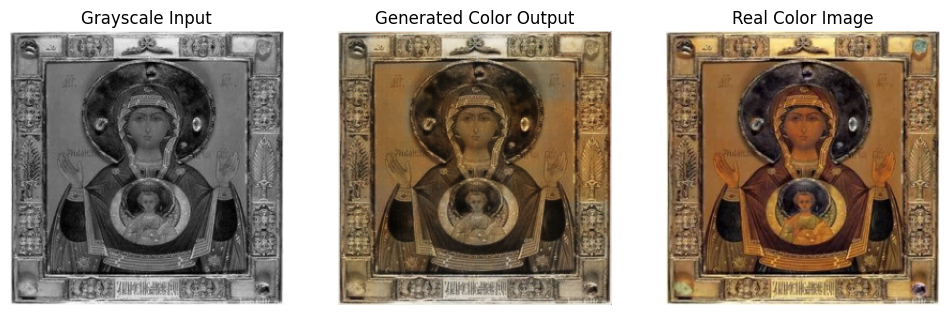

In [17]:
net_G.eval()
net_D.eval()

model = MainModel(net_G=net_G, net_D=net_D).to(device)

def visualize_model_outputs(model, data_loader, device, num_images=1):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model.net_G(inputs)  # Assuming net_G is your generator model

            # Process only the first 'num_images' in the batch
            for i in range(min(num_images, inputs.size(0))):
                # Convert tensors to numpy arrays
                input_np = inputs[i].cpu().numpy().squeeze()
                output_np = outputs[i].cpu().numpy().squeeze()
                target_np = targets[i].cpu().numpy().squeeze()

                # Plotting
                fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

                # Display grayscale input image
                axs[0].imshow(input_np, cmap='gray')
                axs[0].title.set_text('Grayscale Input')
                axs[0].axis('off')

                # Display generated image
                axs[1].imshow(output_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[1].title.set_text('Generated Color Output')
                axs[1].axis('off')

                # Display real color image
                axs[2].imshow(target_np.transpose(1, 2, 0))  # Adjust dimensions as needed
                axs[2].title.set_text('Real Color Image')
                axs[2].axis('off')

                plt.show()

            break  # Only show 'num_images' from the first batch

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_outputs(model, validation_loader, device, num_images=1)

# evaluations

In [18]:
import torch
import numpy as np
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(image_true, image_test):
    mse = F.mse_loss(image_true, image_test)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

def calculate_mse(image_true, image_test):
    return F.mse_loss(image_true, image_test).item()

def calculate_ssim(image_true, image_test, data_range=1.0, win_size=7):
    # Convert tensors to numpy arrays
    image_true_np = image_true.squeeze().cpu().numpy().transpose((1, 2, 0))
    image_test_np = image_test.squeeze().cpu().numpy().transpose((1, 2, 0))

    # Ensure the window size is odd and smaller than the image dimensions
    win_size = min(win_size, min(image_true_np.shape[:2])-1)
    if win_size % 2 == 0:  # Make the window size odd
        win_size -= 1

    # Calculate SSIM
    ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)
    return ssim_value

In [19]:
def calculate_evaluations(model, validation_loader):
    total_psnr = []
    total_mse = []
    total_ssim = []

    model.eval()
    for grayscale_inputs, original_colors in validation_loader:
        grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

        with torch.no_grad():
            colorized_images = model(grayscale_inputs)

        for colorized, original in zip(colorized_images, original_colors):
            total_psnr.append(calculate_psnr(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_mse.append(calculate_mse(original.unsqueeze(0), colorized.unsqueeze(0)))
            total_ssim.append(calculate_ssim(original.unsqueeze(0), colorized.unsqueeze(0), win_size=3))
    mean_psnr = np.mean(total_psnr)
    mean_mse = np.mean(total_mse)
    mean_ssim = np.mean(total_ssim)
    return mean_psnr, mean_mse, mean_ssim

In [20]:
mean_psnr, mean_mse, mean_ssim = calculate_evaluations(net_G, validation_loader)
print(f"Mean PSNR: {mean_psnr:.2f}, Mean MSE: {mean_mse:.4f}, Mean SSIM: {mean_ssim:.4f}")

<ipython-input-18-402a1c129d5a>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image_true_np, image_test_np, data_range=data_range, multichannel=True, win_size=win_size)


Mean PSNR: 26.40, Mean MSE: 0.0044, Mean SSIM: 0.9242


## AUC

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import cv2

def compute_l2_distance(predicted, ground_truth):
    # Calculate L2 distance in ab color space
    l2_distance = torch.sqrt(torch.sum((predicted - ground_truth) ** 2, dim=1))
    return l2_distance

def compute_proportions(l2_distances, thresholds):
    # Calculate the proportion of pixels below each threshold
    proportions = [(l2_distances < t).float().mean().item() for t in thresholds]
    return proportions


def rgb_to_lab(rgb_images):
    lab_images = []
    for img in rgb_images:
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert from PyTorch tensor to NumPy array
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)  # Convert from RGB to Lab
        lab_images.append(torch.tensor(img_np).permute(2, 0, 1))  # Convert back to PyTorch tensor
    return torch.stack(lab_images)  # Stack all tensor images into a single tensor

# Define your thresholds for L2 distance
thresholds = np.linspace(0, 100, num=100)  # Example thresholds

# Initialize an empty list to store L2 distances for all images
all_l2_distances = []

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = net_G(grayscale_inputs)


    # Convert colorized and original images from RGB to Lab
    colorized_images_lab = rgb_to_lab(colorized_images)
    original_colors_lab = rgb_to_lab(original_colors)

    # extract the 'a' and 'b' channels
    predicted_ab = colorized_images_lab[:, 1:, :, :]
    ground_truth_ab = original_colors_lab[:, 1:, :, :]


    l2_distances = compute_l2_distance(predicted_ab, ground_truth_ab)
    all_l2_distances.append(l2_distances)

# Concatenate all L2 distances
all_l2_distances = torch.cat(all_l2_distances, dim=0)

# Compute proportions for each threshold
proportions = compute_proportions(all_l2_distances, thresholds)

# Compute the Area under Curve (AuC) for plotting
auc_value = auc(thresholds, proportions)
print(f"AuC: {auc_value:.4f}")

AuC: 88.6099


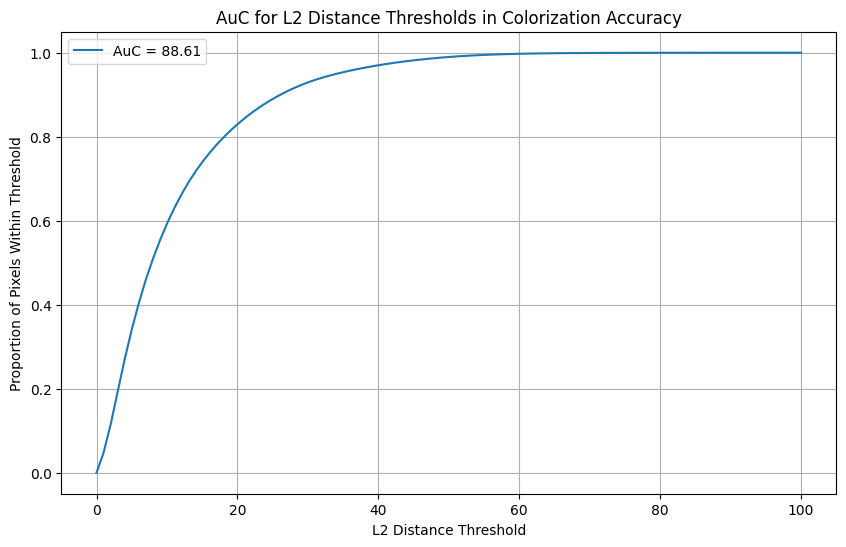

In [22]:
# Plotting the AuC curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, proportions, label=f'AuC = {auc_value:.2f}')
plt.title('AuC for L2 Distance Thresholds in Colorization Accuracy')
plt.xlabel('L2 Distance Threshold')
plt.ylabel('Proportion of Pixels Within Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
import torchvision.models as models
import torchvision.transforms as transforms

# vgg = models.vgg16(pretrained=True).cuda()
vgg = models.resnet50(pretrained=True).cuda()
vgg.eval()

preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizes the image
    # transforms.ToTensor(),  # convert PIL Image to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


correct = 0
total = 0

for grayscale_inputs, original_colors in validation_loader:
    grayscale_inputs, original_colors = grayscale_inputs.cuda(), original_colors.cuda()

    with torch.no_grad():
        colorized_images = net_G(grayscale_inputs)

    colorized_images_vgg = [preprocess(img).unsqueeze(0) for img in colorized_images]
    original_images_vgg = [preprocess(img).unsqueeze(0) for img in original_colors]

    for colorized_img, original_img in zip(colorized_images_vgg, original_images_vgg):
        colorized_pred = vgg(colorized_img.cuda()).argmax(dim=1)
        original_pred = vgg(original_img.cuda()).argmax(dim=1)

        correct += int(colorized_pred == original_pred)
        total += 1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [24]:
# Calculate the accuracy
accuracy = correct / total
print(f"Semantic Interpretability Accuracy: {accuracy:.4f}, where correct = {correct} and total = {total}")

Semantic Interpretability Accuracy: 0.4357, where correct = 373 and total = 856
